In [208]:
# %load_ext watermark
%watermark -a Chan -d -v -p numpy,pandas,sklearn,konlpy,tensorflow,matplotlib

Chan 2019-08-07 

CPython 3.7.3
IPython 7.6.1

numpy 1.16.4
pandas 0.24.2
sklearn 0.21.2
konlpy 0.5.1
tensorflow 1.13.1
matplotlib 3.1.0


In [210]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
import tensorflow as tf
from tensorflow.python.keras.preprocessing import sequence
from tensorflow import keras
from tqdm import tqdm
from collections import Counter
from matplotlib import pyplot as plt

# Load datasets

In [188]:
datasets = pd.DataFrame()
for i in range(1,5):
    print(i)
    dump = pd.read_csv("../../data/sample ({}).csv".format(i), engine='python',names=['chat','label'])
    datasets = pd.concat([datasets, dump])
datasets.head()

1
2
3
4


,chat,label
0,자기잘못인거알면 중고딩도 먼저사과하는걸아는데,0
1,싹둑이 채팅창 관리 중입니다,0
2,싹둑이 채팅창 관리 중입니다,0
3,어제 어글 아직도 가? 개인적으로 사과하셨대 그만해 칭구들앙,0
4,케읍이 뭔데요 무슨사건있엇음?,0


In [189]:
datasets.reset_index(drop=True,inplace=True)

In [190]:
datasets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 2 columns):
chat     3500 non-null object
label    3500 non-null int64
dtypes: int64(1), object(1)
memory usage: 54.8+ KB


In [191]:
datasets.label = datasets.label.astype('int')

In [333]:
len(datasets[datasets.label ==1])/ len(datasets[datasets.label ==0]) # 유해한 레이블의 데이터가 많이 부족함 데이터 편향

0.16163292399601725

# Tokenize
## 형태소분석

In [192]:
morp = Okt()

In [194]:
morped = [morp.pos(_, norm=True, join=True) for _ in tqdm(datasets.chat)] # Stemming은 하지 않는다.






  0%|                                                                                         | 0/3500 [00:00<?, ?it/s]




  1%|▋                                                                              | 33/3500 [00:00<00:10, 320.57it/s]




  2%|█▍                                                                             | 61/3500 [00:00<00:11, 306.27it/s]




  2%|█▉                                                                             | 86/3500 [00:00<00:12, 283.06it/s]




  3%|██▍                                                                           | 109/3500 [00:00<00:14, 229.88it/s]




  5%|███▋                                                                          | 166/3500 [00:00<00:11, 279.20it/s]




  6%|████▌                                                                         | 204/3500 [00:00<00:11, 295.60it/s]




  7%|█████▏                                                                        | 235/3500 [00:00<00:12, 270.06it/s]




  8

 79%|████████████████████████████████████████████████████████████▌                | 2755/3500 [00:08<00:05, 127.78it/s]




 80%|█████████████████████████████████████████████████████████████▏               | 2784/3500 [00:08<00:04, 152.36it/s]




 81%|██████████████████████████████████████████████████████████████▏              | 2826/3500 [00:08<00:03, 187.37it/s]




 81%|██████████████████████████████████████████████████████████████▋              | 2851/3500 [00:08<00:03, 199.24it/s]




 82%|███████████████████████████████████████████████████████████████▎             | 2876/3500 [00:08<00:02, 211.12it/s]




 83%|████████████████████████████████████████████████████████████████▏            | 2919/3500 [00:09<00:02, 248.76it/s]




 85%|█████████████████████████████████████████████████████████████████            | 2959/3500 [00:09<00:01, 279.45it/s]




 85%|█████████████████████████████████████████████████████████████████▊           | 2992/3500 [00:09<00:02, 228.49it/s]




 86%|███

In [342]:
morped[:5]

[['자기/Noun',
  '잘못/Noun',
  '인거/Josa',
  '알/Noun',
  '면/Josa',
  '중/Noun',
  '고딩/Noun',
  '도/Josa',
  '먼저/Noun',
  '사과/Noun',
  '하/Suffix',
  '는/Josa',
  '걸아는데/Verb'],
 ['싹둑/Noun',
  '이/Josa',
  '채팅/Noun',
  '창/Noun',
  '관리/Noun',
  '중/Noun',
  '입니다/Adjective'],
 ['싹둑/Noun',
  '이/Josa',
  '채팅/Noun',
  '창/Noun',
  '관리/Noun',
  '중/Noun',
  '입니다/Adjective'],
 ['어제/Noun',
  '어글/Noun',
  '아직도/Adverb',
  '가/Verb',
  '?/Punctuation',
  '개인/Noun',
  '적/Suffix',
  '으로/Josa',
  '사과/Noun',
  '하셨대/Verb',
  '그만해/Adjective',
  '칭구들앙/Noun'],
 ['케읍/Noun',
  '이/Josa',
  '뭔/Modifier',
  '데/Noun',
  '요/Josa',
  '무슨/Modifier',
  '사건/Noun',
  '있/Adjective',
  '엇음/Noun',
  '?/Punctuation']]

## Dictionary
최빈 형태소에 대한 단어사전 구성

In [196]:
vocab_size = 5000

pad_id = 0
oov_id = 1
index_offset = 1

def make_vocab(sentences):
    word_counter = Counter()

    for sent in sentences:
        word_counter.update(sent)

    most_common = word_counter.most_common()
    print("고빈도 단어:")
    for k, v in most_common[:10]:
        print(k, ": ", v)

        vocab = {
        '<PAD>': pad_id,
        '<OOV>': oov_id
        }
    for i, (word, cnt) in enumerate(most_common, start=index_offset+1):
        vocab[word] = i
        if len(vocab) >= vocab_size:
            break

    return vocab

word_index = make_vocab(morped)
word_inverted_index = {v:k for k, v in word_index.items()}

print("\n단어 사전:")
for i in range(0, 10):
    print(i, word_inverted_index[i])

print("\n단어 사전 크기: ", len(word_index))

고빈도 단어:
형/Suffix :  724
이/Josa :  706
샤/Noun :  587
나왔/Verb :  562
브베/Noun :  442
창/Noun :  420
채팅/Noun :  417
중/Noun :  408
입니다/Adjective :  408
싹둑/Noun :  407

단어 사전:
0 <PAD>
1 <OOV>
2 형/Suffix
3 이/Josa
4 샤/Noun
5 나왔/Verb
6 브베/Noun
7 창/Noun
8 채팅/Noun
9 중/Noun

단어 사전 크기:  3421


In [197]:
def index_to_text(indexes):
    return ' '.join([word_inverted_index[i] for i in indexes])

def text_to_index(tokens):
    indexes = []
    for tok in tokens:
        if tok in word_index:
            indexes.append(word_index[tok])
        else:
            indexes.append(oov_id)

    return indexes

print("원본: ", morped[0])
ids = text_to_index(morped[0])
print("문자 -> 숫자: ", ids)
print("숫자 -> 문자: ", index_to_text(ids))

원본:  ['자기/Noun', '잘못/Noun', '인거/Josa', '알/Noun', '면/Josa', '중/Noun', '고딩/Noun', '도/Josa', '먼저/Noun', '사과/Noun', '하/Suffix', '는/Josa', '걸아는데/Verb']
문자 -> 숫자:  [234, 781, 782, 381, 293, 9, 1292, 58, 1293, 235, 93, 60, 1294]
숫자 -> 문자:  자기/Noun 잘못/Noun 인거/Josa 알/Noun 면/Josa 중/Noun 고딩/Noun 도/Josa 먼저/Noun 사과/Noun 하/Suffix 는/Josa 걸아는데/Verb


# Padding

In [199]:
x_variable = [text_to_index(_) for _ in morped]

sentence_size = 20
x_padded = sequence.pad_sequences(x_variable,
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)

# Data Split

In [200]:
X_train, X_test, y_train, y_test = train_test_split(x_padded, datasets.label)

print("train_inputs shape: ", X_train.shape)
print("test_inputs shape: ", X_test.shape)
print("train_labels shape: ", y_train.shape)
print("test_labels shape: ", y_test.shape)

train_inputs shape:  (2625, 20)
test_inputs shape:  (875, 20)
train_labels shape:  (2625,)
test_labels shape:  (875,)


# Model

In [213]:
import warnings
warnings.filterwarnings(action='once')

In [285]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 10),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.3),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation=tf.nn.sigmoid)
])

In [286]:
def plot_loss(history):
    plt.figure(figsize=(6,5))
    val = plt.plot(history.epoch, history.history['val_loss'],
                 '--', label='Test')
    plt.plot(history.epoch, history.history['loss'], color=val[0].get_color(),
           label='Train')

    plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.legend()

    plt.xlim([0,max(history.epoch)])

def eval_model(model):
    test_loss, test_acc = model.evaluate(X_test, pd.get_dummies(y_test))
    print('Test accuracy:', test_acc)

Train on 2625 samples, validate on 875 samples
Epoch 1/5
2625/2625 [==============================] - ETA: 2:20 - loss: 0.6896 - acc: 0.531 - ETA: 34s - loss: 0.6815 - acc: 0.648 - ETA: 19s - loss: 0.6755 - acc: 0.69 - ETA: 12s - loss: 0.6667 - acc: 0.73 - ETA: 10s - loss: 0.6640 - acc: 0.74 - ETA: 8s - loss: 0.6591 - acc: 0.7542 - ETA: 7s - loss: 0.6544 - acc: 0.762 - ETA: 6s - loss: 0.6420 - acc: 0.780 - ETA: 5s - loss: 0.6377 - acc: 0.782 - ETA: 5s - loss: 0.6314 - acc: 0.788 - ETA: 4s - loss: 0.6222 - acc: 0.797 - ETA: 4s - loss: 0.6127 - acc: 0.803 - ETA: 3s - loss: 0.5984 - acc: 0.812 - ETA: 3s - loss: 0.5886 - acc: 0.816 - ETA: 2s - loss: 0.5797 - acc: 0.819 - ETA: 2s - loss: 0.5669 - acc: 0.825 - ETA: 2s - loss: 0.5588 - acc: 0.827 - ETA: 2s - loss: 0.5518 - acc: 0.828 - ETA: 2s - loss: 0.5482 - acc: 0.828 - ETA: 1s - loss: 0.5399 - acc: 0.830 - ETA: 1s - loss: 0.5347 - acc: 0.831 - ETA: 1s - loss: 0.5183 - acc: 0.837 - ETA: 0s - loss: 0.5107 - acc: 0.841 - ETA: 0s - loss: 0.50

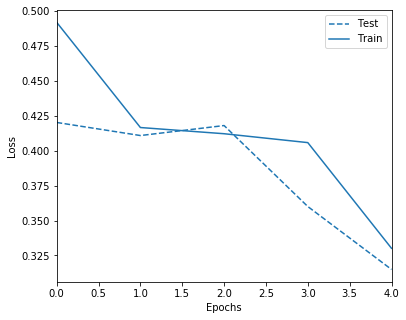

In [287]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train,
          pd.get_dummies(y_train),
          epochs=5,
          validation_data=(X_test, pd.get_dummies(y_test))
         )
plot_loss(history)
eval_model(model)

In [340]:
set(model.predict_classes(X_test)) ## 전부 0으로 예측을 함 . 데이터 편향 문제때문

{0}

In [341]:
# result = pd.DataFrame(np.apply_along_axis(index_to_text, 1, X_test))
# result['predict'] = model.predict_proba(X_test)[:,1] # 유해하다고 판별할 확률
# result[result.predict>0.3]

# TODO
- 형태소별 Tokenize 말고 한글 자모별 Tokenize 하여 실험해보기
- CNN layer / Parameter 변경시켜보기
- 예측 결과 검정하기
    - Attention 이용

# 데이터 편향 문제 해결하자